In [45]:
import re
import os
from collections import defaultdict

import wandb
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf as om
import matplotlib.pyplot as plt

In [46]:
api = wandb.Api()
project_name = "mosaic-ml/neural-data-filtering"

In [61]:
# # Baseline vs offline comparison
# groups = {
#     "mpt-passes-1-final-3B-52B-baseline": "baseline",
#     "mpt-passes-1-final-3B-52B-offline-hard-0.5-ref-125M-26B": "offline-global",
#     "mpt-passes-1-final-3B-52B-offline-local-hard-0.5-ref-125M-26B": "offline-local",
# }

# # PILE Baseline vs offline comparison
# groups = {
#     "pile-passes-0.5-final-1B-26B-baseline": "baseline",
#     "pile-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-125M-26B": "offline-global",
# }

# MPT commesurate step sizes
groups = {
    "mpt-passes-0.5-final-1B-26B-baseline": "baseline",
    "mpt-passes-0.5-final-1B-26B-offline-global-hard-0.5-ref-125M-26B": "global-hard",
    "mpt-passes-0.5-final-1B-26B-offline-local-hard-0.5-ref-125M-26B": "local-hard",
    "mpt-passes-0.5-final-1B-26B-offline-global-mid-0.5-ref-125M-26B": "global-mid",
    "mpt-passes-0.5-final-1B-26B-offline-local-mid-0.5-ref-125M-26B": "local-mid",
}

# 2.5 vs 1.4 epoch comparisons
# groups = {
#     "mpt1.5-3b-params-52b-tokens-1.4x-epoch-raw-proportion": "raw-mix-5T-setting",
#     "mpt1.5-3b-params-52b-tokens-2.5x-epoch-raw-proportion": "raw-mix-10T-setting",
# }

In [62]:
raw = False
SEQ_LEN = 2048
BATCH_SIZE = 512
LR = 0.0002
filters = {}

In [63]:
runs = api.runs(project_name, filters=filters)

In [64]:
categories = ["average", "world_knowledge", "commonsense_reasoning", "language_understanding", "symbolic_problem_solving", "reading_comprehension"]
metric_names = [os.path.join("icl", "metrics", f"{'raw_' if raw else ''}eval_gauntlet", category) for category in categories[1:]]

In [65]:
raw_group_results = {group: defaultdict(list) for group in groups.keys()} 
for run in tqdm(runs):
    group = run.group
    name = run.name


    if group not in groups:
        continue
    if "ignore" in run.tags:
        continue
    try:
        if run.config["optimizer"]["lr"] != LR:
            continue
        if run.config["global_train_batch_size"] != BATCH_SIZE:
            continue
        if run.config["max_seq_len"] != SEQ_LEN:
            continue
    except:
        continue
    
    history = run.scan_history(keys=metric_names + ["time/batch"])
    for row in history:
        # try:
        batch = row["time/batch"]
        metrics = [row[metric_name] for metric_name in metric_names] 
        average = np.mean(metrics) 
        metrics = [average] + metrics
        raw_group_results[group][batch].append(metrics)
        # except Exception as e:
        #     print(f"Failed for run: {name}")
        #     print(f"Exception: {e}")

100%|██████████| 84/84 [00:42<00:00,  1.97it/s]


In [66]:
group_results = {k: {step: np.mean(metrics, axis=0) for step, metrics in v.items()} for k, v in raw_group_results.items()}

In [67]:
runs_to_show = ["baseline", "global-hard", "local-hard", "global-mid", "local-mid"]

In [68]:
# print(group_results)

| average | world_knowledge | commonsense_reasoning | language_understanding | symbolic_problem_solving | reading_comprehension |
| baseline | 0.1365 | 0.1331 | 0.1879 | 0.2034 | 0.0158 | 0.1424 |
| global-hard | 0.1067 | 0.1006 | 0.1898 | 0.2099 | 0.0093 | 0.0238 |
| local-hard | 0.1145 | 0.1060 | 0.1726 | 0.1978 | 0.0143 | 0.0818 |
| global-mid | 0.1123 | 0.1024 | 0.2125 | 0.2045 | 0.0177 | 0.0244 |
| local-mid | 0.1205 | 0.1211 | 0.1704 | 0.1947 | 0.0109 | 0.1053 |


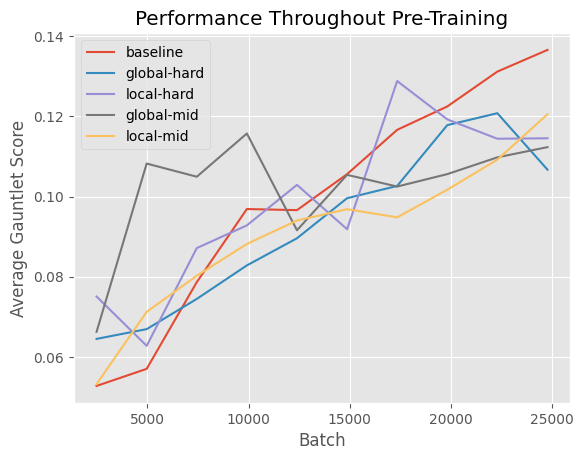

In [69]:
plt.style.use('ggplot')
print("| " + " | ".join(categories) + " |")
for run_name, step_metrics in group_results.items():
    steps = sorted(step_metrics.keys())
    averages = [step_metrics[step][0] for step in steps]
    plt.plot(steps, averages, label=groups[run_name])
    metrics = step_metrics[steps[-1]].tolist()
    metrics = [f"{metric:.4f}" for metric in metrics]
    print(f"| {groups[run_name]} | {' | '.join(metrics)} |")
plt.legend()
plt.ylabel("Average Gauntlet Score")
plt.xlabel("Batch")
plt.title("Performance Throughout Pre-Training")
plt.show()

| average | world_knowledge | commonsense_reasoning | language_understanding | symbolic_problem_solving | reading_comprehension |
| baseline | 0.1365 | 0.1331 | 0.1879 | 0.2034 | 0.0158 | 0.1424 |
| global-hard | 0.1067 | 0.1006 | 0.1898 | 0.2099 | 0.0093 | 0.0238 |
| local-hard | 0.1145 | 0.1060 | 0.1726 | 0.1978 | 0.0143 | 0.0818 |
| global-mid | 0.1123 | 0.1024 | 0.2125 | 0.2045 | 0.0177 | 0.0244 |
| local-mid | 0.1205 | 0.1211 | 0.1704 | 0.1947 | 0.0109 | 0.1053 |


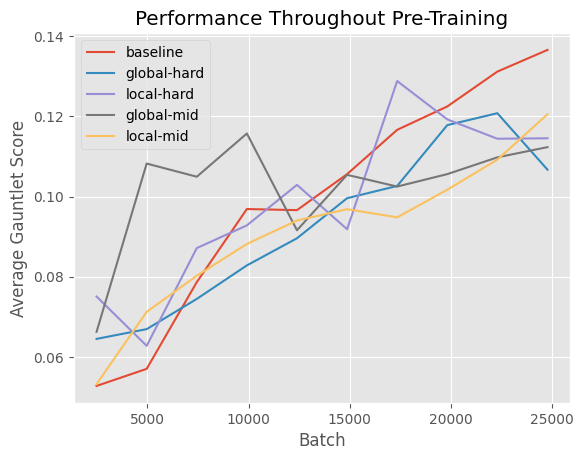

In [70]:
plt.style.use('ggplot')
print("| " + " | ".join(categories) + " |")
for run_name, step_metrics in group_results.items():
    steps = sorted(step_metrics.keys())
    averages = [step_metrics[step][0] for step in steps]
    plt.plot(steps, averages, label=groups[run_name])
    metrics = step_metrics[steps[-1]].tolist()
    metrics = [f"{metric:.4f}" for metric in metrics]
    print(f"| {groups[run_name]} | {' | '.join(metrics)} |")
plt.legend()
plt.ylabel("Average Gauntlet Score")
plt.xlabel("Batch")
plt.title("Performance Throughout Pre-Training")
plt.show()

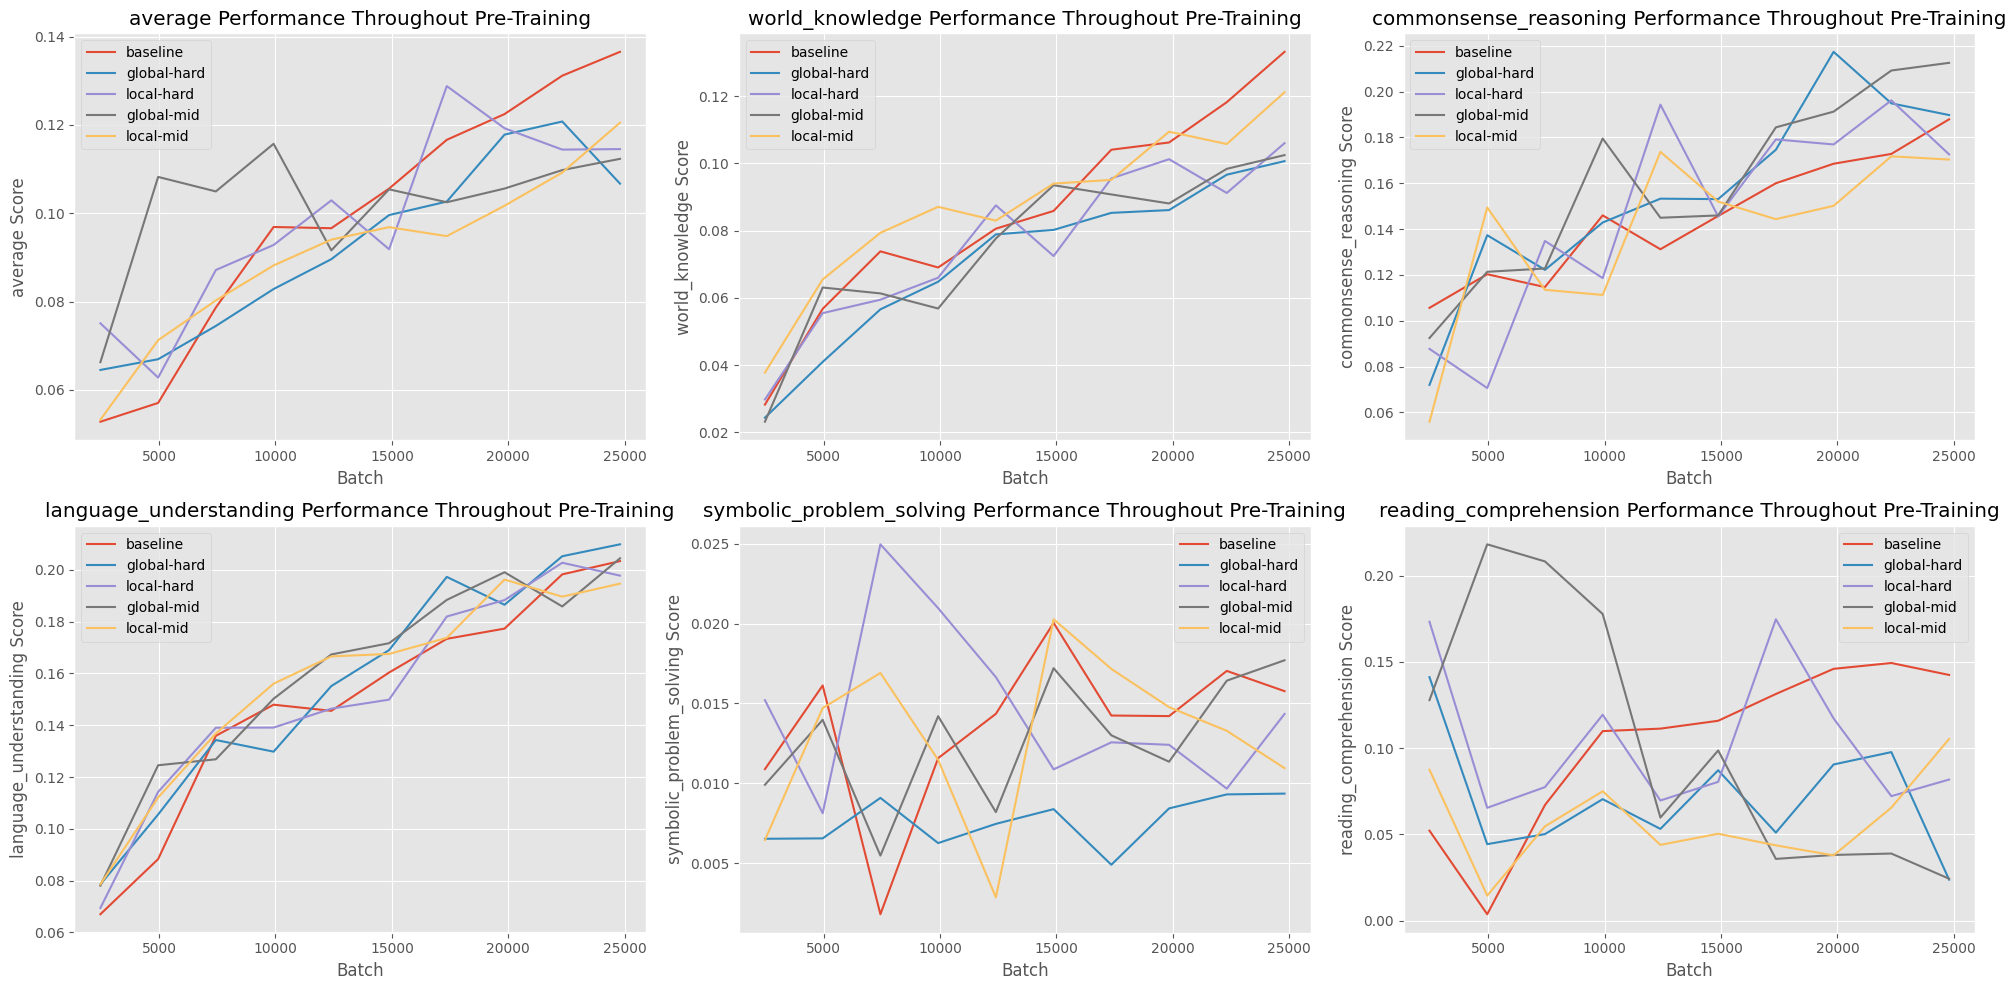

In [71]:
import math

# Calculate the number of rows needed for the subplots
rows = math.ceil(len(categories) / 3)

fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))  # Create a grid of subplots

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over each category (metric)
for i, category in enumerate(categories):
    
    # Iterate over each run
    for run_name, step_metrics in group_results.items():
        steps = sorted(step_metrics.keys())
        
        # Get the metric values for the current category
        metrics = [step_metrics[step][i] for step in steps]
        
        axs[i].plot(steps, metrics, label=groups[run_name])
    
    axs[i].legend()
    axs[i].set_ylabel(f"{category} Score")
    axs[i].set_xlabel("Batch")
    axs[i].set_title(f"{category} Performance Throughout Pre-Training")

# Remove any unused subplots
for i in range(len(categories), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()

# Save the figure to disk
plt.savefig("figs/gauntlet.png")

plt.show()

IndexError: list index out of range

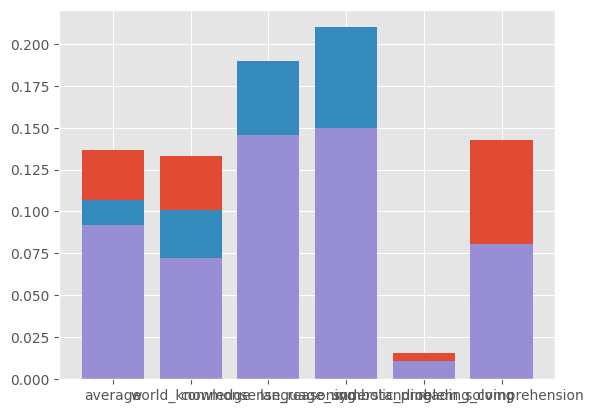

In [39]:
for run_name, step_metrics in group_results.items():
    steps = sorted(step_metrics.keys())
    final_perfs = step_metrics[steps[-1]]
    plt.bar(categories, final_perfs)
    # plt.plot(steps, averages, label=groups[run_name])
    # metrics = step_metrics[steps[-1]].tolist()
    # metrics = [f"{metric:.4f}" for metric in metrics]
    # print(f"| {groups[run_name]} | {' | '.join(metrics)} |")

plt.xlabel('Run')
plt.ylabel('Scores')
plt.title('Scores by run and metric')
plt.xticks(np.arange(len(group_results.keys())), group_results.keys())
plt.legend()

plt.tight_layout()
plt.show()

